# DSG Example: Guidance, Navigation & Control Architecture

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jbussemaker/adsg-core/HEAD?labpath=docs%2Fexample_gnc.ipynb)

This notebook presents an example Guidance, Navigation & Control Architecture problem from Crawley et al.:

Crawley, E., Cameron, B., & Selva, D. (2015). System architecture: strategy and product development for complex systems. Prentice Hall Press. ISBN: 0133975347

The problem involves the selection and connection of sensors to flight computers, and flight computers to actuators.
For simplicity, only the sensors and (flight) computers are modeled here.

- System-level mass (minimization) and failure rate (maximization) are optimized
- The number of sensors and computers can be chosen (1, 2, or 3) --> more reduces failure rate but increases mass
- The types of sensors and computers can be chosen (A, B, or C) --> each has a different mass/failure rate trade-off
- Connections between sensors and computers are established
  - Any sensor can connect to any computer
  - Each sensor and computer need at least one connection (otherwise their existence is useless)
- Sensor/computer type selections are constrained to be non-repeatable
  - E.g. sensor types can be AA, AB, AC, BB, BC, CC (no permutations of these)
  - This is to prevent including isomorphic architectures, architectures where sensors and/or computers, including
    their connections, are permutations of each other and therefor have the same objective values

The GNC problem is implemented in `adsg_core.examples.gnc.GNCEvaluator`, however here explained in more details.

## DSG

The DSG consists of two node clusters for sensor and computer choices, and a connection choice for connection between the clusters.

We start by defining two custom node types that make it easier to later interpret DSG instances.

In [1]:
from adsg_core import BasicDSG, NamedNode, MetricNode, \
    MetricType, ConnectorNode

class GNCInstanceNode(NamedNode):
    """Custom node that represents the instance of some object"""

    def __init__(self, base_name: str, idx: int):
        self.idx = idx
        super().__init__(base_name)

    def get_export_title(self) -> str:
        return f'{self.name}[{self.idx}]'


class GNCTypeNode(NamedNode):
    """Custom node that represents the type of some object"""

    def __init__(self, name: str, type_: str):
        self.type = type_
        super().__init__(name)

    def get_export_title(self) -> str:
        return f'{self.name}: {self.type}'

In [2]:
# Create the DSG
dsg = BasicDSG()

# Add top-level node and metrics
gnc = NamedNode('GNC')
dsg.add_edges([
    (gnc, MetricNode('mass', direction=-1, type_=MetricType.OBJECTIVE)),
    # Failure rate is -log(fr), so we maximize it
    (gnc, MetricNode('failureRate', direction=1, type_=MetricType.OBJECTIVE)),
])

# Set start node
dsg = dsg.set_start_nodes({gnc})
dsg.render()

### Sensors

In [3]:
# Add sensor choices
sensor = NamedNode('Sensor')
dsg.add_edge(gnc, sensor)

# Instance nodes and choice
sensor_inst_nodes = [GNCInstanceNode('Inst', i) for i in range(3)]
dsg.add_selection_choice('S', sensor, sensor_inst_nodes, is_ordinal=True)

# Create type nodes
sensor_type_nodes = [GNCTypeNode('Type', type_) for type_ in ['A', 'B', 'C']]

sensor_type_choices = []
sensor_conn_nodes = []
for i, si_node in enumerate(sensor_inst_nodes):
    # Add type selection
    sensor_type_choices.append(dsg.add_selection_choice(f'ST{i}', si_node, sensor_type_nodes))

    # Connection node, require at least one connection
    conn_node = ConnectorNode(f'SC{i}', deg_spec='+')
    sensor_conn_nodes.append(conn_node)
    dsg.add_edge(si_node, conn_node)

    # Select previous instances
    # This is to ensure that if we want 2 instance,
    # we select both instance 1 and 2, etc.
    if i > 0:
        dsg.add_edge(si_node, sensor_inst_nodes[i-1])

dsg.render()
dsg.render_legend(['NODE_START', 'METRICS_OUTPUTS', 'EDGE_DERIVE', 'CHOICE_SEL'])

### Computers

In [4]:
# Add computer choices
computer = NamedNode('Comp')
dsg.add_edge(gnc, computer)

# Instance nodes and choice
comp_inst_nodes = [GNCInstanceNode('Inst', i) for i in range(3)]
dsg.add_selection_choice('C', computer, comp_inst_nodes, is_ordinal=True)

# Create type nodes
comp_type_nodes = [GNCTypeNode('Type', type_) for type_ in ['A', 'B', 'C']]

comp_type_choices = []
comp_conn_nodes = []
for i, ci_node in enumerate(comp_inst_nodes):
    # Add type selection
    comp_type_choices.append(dsg.add_selection_choice(f'CT{i}', ci_node, comp_type_nodes))

    # Connection node, require at least one connection
    conn_node = ConnectorNode(f'CC{i}', deg_spec='+')
    comp_conn_nodes.append(conn_node)
    dsg.add_edge(ci_node, conn_node)

    # Select previous instances
    if i > 0:
        dsg.add_edge(ci_node, comp_inst_nodes[i-1])

dsg.render()

### Connections and Constraints

In [5]:
# Add connection choice
dsg.add_connection_choice('Conn', sensor_conn_nodes, comp_conn_nodes)

dsg = dsg.set_start_nodes({gnc})
dsg.render()
dsg.render_legend(['NODE_START', 'METRICS_OUTPUTS', 'EDGE_DERIVE', 'CHOICES'])

The last thing to add is a choice constraint on the type selection choices.
This is needed, because for mass calculation the order of type selections does not matter, and for failure rate calculation it would be possible to create isomorphic graphs by exchanging types and connections simultaneously.

By adding an *unordered combinations* constraint to type selection, we prevent creating these isomorphic graphs and thereby save computational resources.

In [6]:
from adsg_core import GraphProcessor, ChoiceConstraintType
n_valid = GraphProcessor(dsg).get_n_valid_designs()
print(f'Valid architectures: {n_valid}')

Valid architectures: 206127


In [7]:
# Constraint sensor/computer type selections
# "Unordered" constraints are shown by purple-dashed edges annotated with "≥"
dsg = dsg.constrain_choices(ChoiceConstraintType.UNORDERED, comp_type_choices)
dsg = dsg.constrain_choices(ChoiceConstraintType.UNORDERED, sensor_type_choices)

n_valid_constrained = GraphProcessor(dsg).get_n_valid_designs()
print(f'Valid architectures: {n_valid_constrained} '
      f'({100*(n_valid-n_valid_constrained)/n_valid:.1f}% reduction)')

dsg.render()
dsg.render_legend(['NODE_START', 'METRICS_OUTPUTS', 'EDGE_DERIVE', 'CHOICES', 'CHOICE_CONSTRAINT'])

Valid architectures: 29857 (85.5% reduction)


## Optimization Problem

We can now encode the optimization problem and inspect some properties.

In [8]:
from adsg_core import GraphProcessor

gp = GraphProcessor(dsg)
gp.get_statistics()

,n_valid,n_declared,n_discrete,n_dim_cont,n_dim_cont_mean,n_exist,imp_ratio,imp_ratio_comb,imp_ratio_cont,inf_idx,dist_corr,encoder
type,,,,,,,,,,,,
option-decisions,361,6561,8,0,0.0,1,18.174515,18.174515,1.0,0.599330,0.0,complete
permutation-decision-0 Conn,327,512,9,0,0.0,9,14.091743,14.091743,1.0,1.000000,1.0,Assigning Pattern Encoder
total-design-space,29857,3359232,17,0,0.0,1,112.510701,112.510701,1.0,0.773706,0.0,complete
total-design-problem,29857,3359232,17,0,0.0,1,112.510701,112.510701,1.0,0.773706,0.0,complete


The selection choices (`option-decisions`) lead to 361 valid architectures.
The connection choice (`permutation-decision`) to an additional 327 valid architectures, and is encoded by the assigning pattern encoder.

In total, there are 29857 valid architectures, however by just looking at the 17 design variables there are about 3.3 million combinations.
This discrepancy is captured in the *imputation ratio*:
`imp_ratio = n_declared / n_valid = 3359232 / 29857 = 112.5`

### Evaluation Function

The evaluation function should interpret the ADSG and get a list of sensor and computer types, and a list of connection from sensors to computers.
The metrics are then calculated by the `GNCEvaluator`.

The evaluation function is provided by implementing the `_evaluate` function of an extended `ADSGEvaluator` class.

In [9]:
from typing import List, Dict
from adsg_core import DSGEvaluator, DSGType, EdgeType
from adsg_core.examples.gnc import GNCEvaluator

class ExampleGNCEvaluator(DSGEvaluator):

    def _evaluate(self, dsg_inst: DSGType, metric_nodes: List[MetricNode])\
            -> Dict[MetricNode, float]:

        # Define a function to analyze either sensors or computers
        def _analyze_object(object_root_node):
            obj_types = []
            connector_nodes = {}

            # Find object instance nodes
            inst_nodes = []
            for obj_inst_node in dsg_inst.derived_nodes(object_root_node):
                if isinstance(obj_inst_node, GNCInstanceNode):
                    inst_nodes.append(obj_inst_node)

            # Loop over sorted instance nodes
            for i, obj_inst_node in enumerate(
                    sorted(inst_nodes, key=lambda n: n.idx)):

                # Loop over outgoing nodes
                for next_node in dsg_inst.next(obj_inst_node):
                    # Record selected type
                    if isinstance(next_node, GNCTypeNode):
                        obj_types.append(next_node.type)

                    # Record connector nodes
                    elif isinstance(next_node, ConnectorNode):
                        connector_nodes[next_node] = i

            return obj_types, connector_nodes

        # Analyze sensors and computers
        sensors, sensor_conns = [], {}
        computers, comp_conns = [], {}
        for node in dsg_inst.graph.nodes:
            if isinstance(node, NamedNode):
                if node.name == 'Sensor':
                    sensors, sensor_conns = _analyze_object(node)
                elif node.name == 'Comp':
                    computers, comp_conns = _analyze_object(node)

        # Get object connections
        conns = []
        for src_node, src_idx in sensor_conns.items():
            # Loop over outgoing edges, filtered by connection type edges
            for tgt_node in dsg_inst.next(src_node,
                                          edge_type=EdgeType.CONNECTS):
                tgt_idx = comp_conns[tgt_node]
                conns.append((src_idx, tgt_idx))

        # Calculate metrics: the outputs of this function should be a dict
        # mapping requested metric nodes to values
        results = {}
        for metric_node in metric_nodes:
            if metric_node.name == 'mass':
                results[metric_node] = GNCEvaluator.calc_mass(
                    sensors, computers)
            elif metric_node.name == 'failureRate':
                results[metric_node] = GNCEvaluator.calc_failure_rate(
                    sensors, computers, conns)

        return results

In [10]:
# Instantiate the evaluator
evaluator = ExampleGNCEvaluator(dsg)

# Test some architectures
for i in range(5):
    # Generate random architecture
    dv = evaluator.get_random_design_vector()
    graph, dv_corr, is_active = evaluator.get_graph(dv)

    # Evaluate it
    obj, con = evaluator.evaluate(graph)
    print(f'Architecture {i+1}: {list(dv_corr)}')
    print(f'  Objectives: {list(obj)}')

Architecture 1: [1, 2, 1, 1, 0, 1, 2, 2, 0, 1, 1, 1, 1, 0, 0, 0, 0]
  Objectives: [5.203805270559525, 34.0]
Architecture 2: [2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
  Objectives: [2.9967401209647577, 31.0]
Architecture 3: [2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]
  Objectives: [5.817080490893296, 34.0]
Architecture 4: [1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
  Objectives: [2.9961071120837195, 21.0]
Architecture 5: [0, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
  Objectives: [2.999348666877851, 21.0]


### Results

There are a little over 29k architectures, so here it makes sense to run an optimization so that we do not have to evaluate all architectures to find a Pareto front.

We run the optimization problem by coupling to [SBArchOpt](https://sbarchopt.readthedocs.io/).
SBArchOpt is an open-source library for running architecture optimization problem.
ADSG Core provides a problem definition in the API of SBArchOpt, so that all algorithms defined in SBArchOpt can be used.

Ensure SBArchOpt is installed, or run: `pip install adsg-core[opt]`

We run the optimization using the NSGA-II algorithm, a multi-objective genetic algorithm.
For more information refer to the SBArchOpt [documentation](https://sbarchopt.readthedocs.io/en/latest/algo/pymoo/).
SBArchOpt is based on [pymoo](https://pymoo.org), so it can also be helpful to consult its documentation.

In [11]:
# Get the SBArchOpt problem
problem = evaluator.get_problem()

# Now the SBArchOpt API is available
# We can for example print some problem statistic
problem.print_stats()

problem: DSGArchOptProblem(<__main__.ExampleGNCEvaluator object at 0x00000257632B21F0>)
n_discr: 17
n_cont : 0
n_obj  : 2
n_con  : 0
MD     : False
MO     : True
HIER         : True
n_valid_discr: 29857
imp_ratio    : 112.51 (discr.: 112.51; cont.: 1.00)
corr_ratio   : 6.50 (discr.: 6.50; cont.: 1.00; fraction of imp_ratio: 39.6%)
                        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9       x10       x11       x12       x13       x14       x15       x16       max
inactive                                        0.001909  0.061192            0.001909  0.061192            0.000301  0.001507  0.003517  0.011957  0.011957  0.112436  0.112436  0.112436          
opt 0             0.001909  0.001909  0.593563  0.292081       0.1  0.593563  0.292081       0.1  0.382892  0.383007   0.38347  0.384243  0.385085  0.385085  0.392453  0.392453  0.392453          
opt 1             0.059283  0.059283   0.30204   0.39604       0.3   0.30204

In [12]:
from pymoo.optimize import minimize
from sb_arch_opt.algo.pymoo_interface import get_nsga2

# Get the optimization algorithm
algorithm = get_nsga2(pop_size=50)

# Run the optimization
result = minimize(problem, algorithm, termination=('n_gen', 10), verbose=True)

print(f'{len(result.opt)} points in the Pareto front')

n_gen  |  n_eval  | n_nds  |      eps      |   indicator   |     hv_est    |   not_failed  |    feasible   |    optimal   
     1 |       50 |     11 |             - |             - |  0.4580836070 |   50 (100.0%) |   50 (100.0%) |    11 (22.0%)
     2 |      100 |     14 |  0.0035834541 |         ideal |  0.5978199266 |   50 (100.0%) |   50 (100.0%) |    14 (28.0%)
     3 |      150 |     18 |  0.0075414853 |         ideal |  0.6337830641 |   50 (100.0%) |   50 (100.0%) |    18 (36.0%)
     4 |      200 |     18 |  0.0053719259 |             f |  0.6377293191 |   50 (100.0%) |   50 (100.0%) |    18 (36.0%)
     5 |      250 |     23 |  0.0177618602 |         ideal |  0.6417328648 |   50 (100.0%) |   50 (100.0%) |    23 (46.0%)
     6 |      300 |     27 |  0.0030801678 |             f |  0.6432227141 |   50 (100.0%) |   50 (100.0%) |    27 (54.0%)
     7 |      350 |     24 |  0.0031216634 |             f |  0.6467414307 |   50 (100.0%) |   50 (100.0%) |    24 (48.0%)
     8 |      40

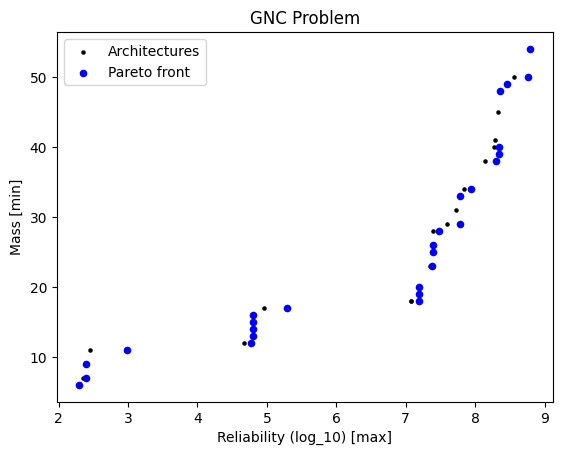

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(), plt.title('GNC Problem')
f_pop = result.pop.get('F')
plt.scatter(-f_pop[:, 0], f_pop[:, 1], s=5, c='k', label='Architectures')
f_opt = result.opt.get('F')
plt.scatter(-f_opt[:, 0], f_opt[:, 1], s=20, c='b', label='Pareto front')
plt.xlabel('Reliability (log_10) [max]'), plt.ylabel('Mass [min]')
plt.legend()
plt.show()

As typical of architecture optimization problems, there is a clear trade-off:
increasing the reliability comes with an increase in mass (and therefore cost).

The trade-off is seen by a Pareto front: the front of points where no point exists that is better in *all* objectives.